[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/demos/openneuro_demo.ipynb)

<font size="6">Logging</font>

 <font size="3">Default logging configurations are provided by NeuroCAPs, which sends logged messages to standard output. However, optionally, logging can be configured prior to package import. For more information about configuring logging, especially for logging with parallel processing, refer to [NeuroCAPs' Logging Documentation](https://neurocaps.readthedocs.io/en/stable/logging.html).</font>

In [1]:
import logging, os

try:
    from rich.logging import RichHandler

    handler = RichHandler()
except:
    import sys

    handler = logging.StreamHandler(sys.stdout)


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(name)s [%(levelname)s] %(message)s",
    handlers=[handler],
)

In [ ]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

Downloading data from OpenNeuro, requires `pip install openneuro-py ipywidgets` or `pip install neurocaps[demo]`. **Note:** Ensure that the "neurocaps_demo" folder is populated before proceeding regardless if the code completes execution. If it is empty, then the contents are still being donwloaded.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
import plotly.io as pio, joblib

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

from openneuro import download

demo_dir = "neurocaps_demo"
os.makedirs(demo_dir, exist_ok=True)

# Include the run-1 data and derivatives of two tasks for two subjects
include = [
    "dataset_description.json",
    "sub-0004/ses-2/func/*run-[12]*events*",
    "sub-0006/ses-2/func/*run-[12]*events*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
]

download(
    dataset="ds005381",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
)

The first level of the fmriprep directory must also have a *"dataset_description.json"* file.

In [2]:
import json

desc = {
    "Name": "fMRIPrep - fMRI PREProcessing workflow",
    "BIDSVersion": "1.0.0",
    "DatasetType": "derivative",
    "GeneratedBy": [
        {"Name": "fMRIPrep", "Version": "20.2.0", "CodeURL": "https://github.com/nipreps/fmriprep"}
    ],
}

with open(
    "neurocaps_demo/derivatives/fmriprep/dataset_description.json", "w", encoding="utf-8"
) as f:
    json.dump(desc, f)

<font size="6">Timeseries Extraction</font>

 <font size="3">To demonstrate timeseries extraction using the `TimeseriesExtractor` class, the single subject dataset used to test the NeuroCAPs package will be downloaded for demonstration. For the timeseries extraction to work, the PyBIDS package must be installed. To install PyBIDS on Windows, you can use `pip install pybids`
 or `pip install neurocaps[windows]`. Additionally, for PyBIDS installation on Windows, you may need to enable long path support. The instructions to do so, involves right clicking on Powershell, selecting "Run as Administrator", and pasting in the Powershell command located in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). An alternative involves installing [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [opening jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/). </font>

In [3]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts

# Setting parcel_approach
parcel_approach = {"Schaefer": {"n_rois": 100}}
# parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = (
    parcel_approach["Schaefer"]["n_rois"]
    if "Schaefer" in parcel_approach.keys()
    else (116 if parcel_approach["AAL"]["version"] != "3v2" else 166)
)

confound_names = [
    "cosine*",
    "trans_x",
    "trans_x_derivative1",
    "trans_y",
    "trans_y_derivative1",
    "trans_z",
    "trans_z_derivative1",
    "rot_x",
    "rot_x_derivative1",
    "rot_y",
    "rot_y_derivative1",
    "rot_z",
    "rot_z_derivative1",
]

# Set up signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin6Asym",
    parcel_approach=parcel_approach,
    standardize=True,
    use_confounds=True,
    confound_names=confound_names,
    low_pass=0.1,
    high_pass=None,
    n_acompcor_separate=2,
    dummy_scans="auto",
    fd_threshold={"threshold": 0.5, "outlier_percentage": 0.30},
)

# Perform the timeseries extraction; only one session can be extracted at a time. Internally, lru_cache is used for
# ``BidsLayout``. May need to clear cache if the cell was ran before the directory download completed
try:
    TimeseriesExtractor._call_layout.cache_clear()
except:
    pass

extractor.get_bold(
    bids_dir="neurocaps_demo",
    session="2",
    task="DET",
    condition="late",
    condition_tr_shift=2,
    slice_time_ref=1,
    n_cores=None,
    tr=2,
    verbose=True,
    progress_bar=True,
)

[07/18/25 23:41:57] WARNING  2025-07-18 23:41:57,093                                ]8;id=838444;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=838742;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#184\184]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2025-07-18 23:41:57,100                                ]8;id=478843;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=694279;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#188\188]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

                    INFO     2025-07-18 23:41:57,108 neurocaps.extraction._internals.confounds      ]8;id=773294;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\confounds.py\confounds.py]8;;\:]8;id=719004;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\confounds.py#66\66]8;;\
                             [INFO] Confound regressors to be used if available: cosine*, trans_x,                 
                             trans_x_derivative1, trans_y, trans_y_derivative1, trans_z,                           
                             trans_z_derivative1, rot_x, rot_x_derivative1, rot_y,                                 
                             rot_y_derivative1, rot_z, rot_z_derivative1.                                          

[07/18/25 23:41:58] INFO     2025-07-18 23:41:58,895                                    ]8;id=264791;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py\timeseries_extractor.py]8;;\:]8;id=796680;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py#799\799]8;;\
                             neurocaps.extraction.timeseries_extractor [INFO] BIDS                                 
                             Layout: ...neurocaps\demos\neurocaps_demo | Subjects: 2 |                             
                             Sessions: 2 | Runs: 4                                                                 

Processing Subjects:   0%|          | 0/2 [00:00<?, ?it/s]

[07/18/25 23:41:59] INFO     2025-07-18 23:41:59,065 neurocaps.extraction._internals.postprocess ]8;id=666588;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=803760;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] Preparing                    
                             for Timeseries Extraction using [FILE:                                                
                             sub-0004_ses-2_task-DET_run-1_space-MNI152NLin6Asym_res-2_desc-prep                   
                             roc_bold.nii.gz].                                                                     

                    INFO     2025-07-18 23:41:59,088 neurocaps.extraction._internals.postprocess ]8;id=36432;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=119097;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] No                           
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:41:59,105 neurocaps.extraction._internals.postprocess ]8;id=410768;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=988410;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] The                          
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, cosine02, cosine03, trans_x, trans_x_derivative1,                           
                             trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                    
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_33,                       
                             a_comp_cor_34.                                                                        

[07/18/25 23:42:10] INFO     2025-07-18 23:42:10,490 neurocaps.extraction._internals.postprocess ]8;id=42290;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=564828;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#706\706]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 1] Nuisance                     
                             regression completed; extracting [CONDITION: late].                                   

                    INFO     2025-07-18 23:42:10,522 neurocaps.extraction._internals.postprocess ]8;id=458705;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=195235;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 2] Preparing                    
                             for Timeseries Extraction using [FILE:                                                
                             sub-0004_ses-2_task-DET_run-2_space-MNI152NLin6Asym_res-2_desc-prep                   
                             roc_bold.nii.gz].                                                                     

                    INFO     2025-07-18 23:42:10,547 neurocaps.extraction._internals.postprocess ]8;id=61756;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=321711;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 2] No                           
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:42:10,563 neurocaps.extraction._internals.postprocess ]8;id=480596;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=916343;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 2] The                          
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, cosine02, cosine03, trans_x, trans_x_derivative1,                           
                             trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                    
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_100,                      
                             a_comp_cor_101.                                                                       

[07/18/25 23:42:21] INFO     2025-07-18 23:42:21,863 neurocaps.extraction._internals.postprocess ]8;id=454692;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=558814;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#706\706]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: DET | RUN: 2] Nuisance                     
                             regression completed; extracting [CONDITION: late].                                   

                    INFO     2025-07-18 23:42:21,895 neurocaps.extraction._internals.postprocess ]8;id=658367;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=665937;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 1] Preparing                    
                             for Timeseries Extraction using [FILE:                                                
                             sub-0006_ses-2_task-DET_run-1_space-MNI152NLin6Asym_res-2_desc-prep                   
                             roc_bold.nii.gz].                                                                     

                    INFO     2025-07-18 23:42:21,916 neurocaps.extraction._internals.postprocess ]8;id=971670;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=154345;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 1] No                           
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:42:21,932 neurocaps.extraction._internals.postprocess ]8;id=58154;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=396454;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 1] The                          
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, cosine02, cosine03, trans_x, trans_x_derivative1,                           
                             trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                    
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_23,                       
                             a_comp_cor_24.                                                                        

[07/18/25 23:42:33] INFO     2025-07-18 23:42:33,293 neurocaps.extraction._internals.postprocess ]8;id=426757;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=746584;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#706\706]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 1] Nuisance                     
                             regression completed; extracting [CONDITION: late].                                   

                    INFO     2025-07-18 23:42:33,328 neurocaps.extraction._internals.postprocess ]8;id=157677;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=546173;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 2] Preparing                    
                             for Timeseries Extraction using [FILE:                                                
                             sub-0006_ses-2_task-DET_run-2_space-MNI152NLin6Asym_res-2_desc-prep                   
                             roc_bold.nii.gz].                                                                     

                    INFO     2025-07-18 23:42:33,351 neurocaps.extraction._internals.postprocess ]8;id=129061;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=411226;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 2] No                           
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:42:33,366 neurocaps.extraction._internals.postprocess ]8;id=563234;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=860075;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 2] The                          
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, cosine02, cosine03, trans_x, trans_x_derivative1,                           
                             trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                    
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_24,                       
                             a_comp_cor_25.                                                                        

[07/18/25 23:42:44] INFO     2025-07-18 23:42:44,753 neurocaps.extraction._internals.postprocess ]8;id=143784;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=342847;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#706\706]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: DET | RUN: 2] Nuisance                     
                             regression completed; extracting [CONDITION: late].                                   

In [4]:
# Print metadata
print(extractor)

Current Object State:
Preprocessed BOLD Template Space                           : MNI152NLin6Asym
Parcellation Approach                                      : Schaefer
Signal Cleaning Parameters                                 : {'masker_init': {'detrend': False, 'low_pass': 0.1, 'high_pass': None, 'smoothing_fwhm': None}, 'standardize': True, 'use_confounds': True, 'confound_names': ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1'], 'n_acompcor_separate': 2, 'dummy_scans': 'auto', 'fd_threshold': {'threshold': 0.5, 'outlier_percentage': 0.3}, 'dtype': None}
Task Information                                           : {'task': 'DET', 'session': '2', 'runs': None, 'condition': 'late', 'condition_tr_shift': 2, 'tr': 2, 'slice_time_ref': 1}
Number of Subjects                                         : 2
CPU Cores Used for Timeseries Extr

In [5]:
import neurocaps

neurocaps.__version__

'0.33.1'

<font size="6">Checking Quality Control Metrics</font>

<font size="3">Checking statistics on framewise displacement and dummy volumes using the `self.report_qc` method. Only censored frames with valid data on both sides are interpolated, while censored frames at the edge of the timeseries (including frames that border censored edges) are always scrubbed and counted in "Frames_Scrubbed". Additionally, [scipy's Cubic Spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) is used to only interpolate censored frames.</font>

In [6]:
df = extractor.report_qc()
df

,Subject_ID,Run,Mean_FD,Std_FD,Frames_Scrubbed,Frames_Interpolated,Mean_High_Motion_Length,Std_High_Motion_Length,N_Dummy_Scans
0,0004,run-1,0.101492,0.056535,0,0,0,0,0
1,0004,run-2,0.104084,0.072763,0,0,0,0,0
2,0006,run-1,0.122558,0.057766,0,0,0,0,0
3,0006,run-2,0.159955,0.085193,0,0,0,0,0


<font size="6">BOLD Visualization</font>

<font size="3">Visualizing bold data using the `self.visualize_bold` method.</font>

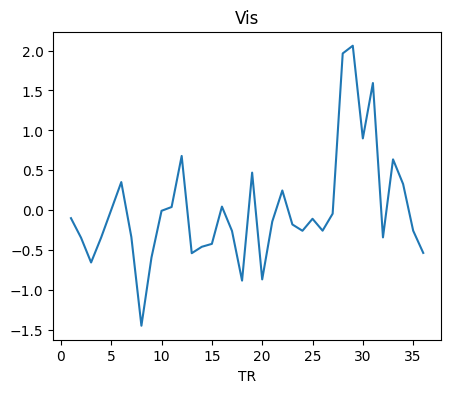

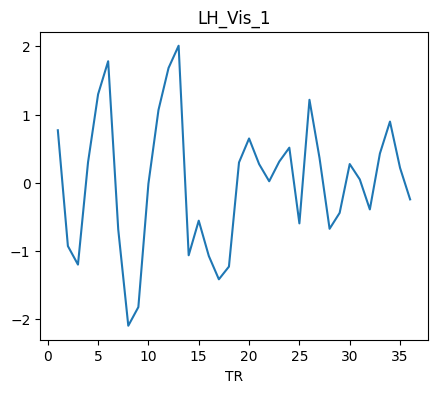

In [7]:
if "AAL" in parcel_approach:
    extractor.visualize_bold(subj_id="0004", run="1", region="Precentral", figsize=(5, 4))

    extractor.visualize_bold(subj_id="0004", run="1", roi_indx=0, figsize=(5, 4))
else:
    extractor.visualize_bold(subj_id="0004", run="1", region="Vis", figsize=(5, 4))

    extractor.visualize_bold(subj_id="0004", run="1", roi_indx="LH_Vis_1", figsize=(5, 4))

 <font size="6">Saving Timeseries as Pickle</font>
 
 <font size="3">`self.get_bold` produces a nested dictionary structure containing the subject id, run id, and the associated timeseries data. This nested dictionary is stored in the `self.subject_timeseries` attribute and can be saved as a pickle file using `self.timeseries_to_pickle`.</font>

In [8]:
output_dir = "neurocaps_demo/neurocaps_outputs"
extractor.timeseries_to_pickle(output_dir=output_dir, filename="DET_timeseries.pkl")

[07/18/25 23:42:45] WARNING  2025-07-18 23:42:45,037 neurocaps.utils._io [WARNING] Creating the following ]8;id=153457;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_io.py\_io.py]8;;\:]8;id=697283;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_io.py#21\21]8;;\
                             non-existent path: neurocaps_demo/neurocaps_outputs.                                  

 <font size="6">Co-Activation Patterns (CAPs) With No Groups</font>
 
 <font size="3">Initializing the `CAP` class and using the saved pickle file as input for `self.get_caps`.  When group is `None`, which is the default value of this parameter, then the default group name is "All Subjects".</font>

                    INFO     2025-07-18 23:42:45,071 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=480816;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=98433;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#75\75]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

                    INFO     2025-07-18 23:42:45,191 neurocaps.analysis.cap._internals.cluster       ]8;id=236901;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=478706;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#288\288]8;;\
                             [INFO] [GROUP: All Subjects | METHOD: davies_bouldin] Optimal cluster                 
                             size is 2.                                                                            

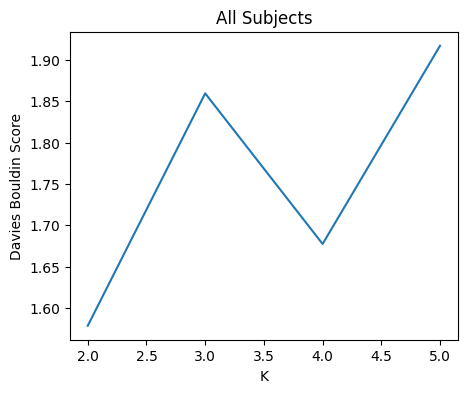

In [9]:
# `parcel_approach` is only required for certain visualization functions and can be set later
# cap_analysis = CAP(parcel_approach = {"Schaefer": {"n_rois": 100}})

cap_analysis = CAP(extractor.parcel_approach, groups=None)

cap_analysis.get_caps(
    subject_timeseries=f"{output_dir}/DET_timeseries.pkl",
    n_clusters=range(2, 6),  # Test k=2 to k=5
    standardize=True,
    cluster_selection_method="davies_bouldin",
    show_figs=True,
    figsize=(5, 4),
)

# The concatenated data can be safely deleted since only the kmeans models and any standardization parameters are
# used for computing temporal metrics.

del cap_analysis.concatenated_timeseries

In [10]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : All Subjects
Number of Clusters                                          : [2, 3, 4, 5]
Cluster Selection Method                                    : davies_bouldin
Optimal Number of Clusters (if Range of Clusters Provided)  : {'All Subjects': 2}
CPU Cores Used for Clustering (Multiprocessing)             : None
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 0 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'All Subjects': 2}
Variance Explained by Clustering                            : {'All Subjects': np.float64(0.25505528360815766)}


<font size="6">Return CAP Labels for Each Subject</font>

In [11]:
cap_labels_dict = cap_analysis.return_cap_labels(
    subject_timeseries=os.path.join(output_dir, "DET_timeseries.pkl")
    )

cap_labels_dict

{'0004': {'run-1': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int32),
  'run-2': array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0], dtype=int32)},
 '0006': {'run-1': array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int32),
  'run-2': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int32)}}

 <font size="6">Calculating CAP Metrics With No Groups</font>

 <font size="3">Getting CAP metrics using the `self.calculate_metrics` method. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability".</font>

In [12]:
# Get metric for the subjects in the `subject_timeseries` pickle file
cap_analysis.calculate_metrics(
    subject_timeseries=f"{output_dir}/DET_timeseries.pkl", metrics="persistence"
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0004,All Subjects,run-1,2.500000,5.200000
1,0004,All Subjects,run-2,3.750000,3.000000
2,0006,All Subjects,run-1,2.000000,3.000000
3,0006,All Subjects,run-2,2.166667,3.166667


 <font size="6">Co-Activation Patterns (CAPs) With Groups</font>
 
 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes). For demonstration purposes, a simulated `subject_timeseries` is created.</font>

                    WARNING  2025-07-18 23:42:45,457                                ]8;id=653136;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=583520;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#184\184]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2025-07-18 23:42:45,461                                ]8;id=128779;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py\_parcellation_validation.py]8;;\:]8;id=721151;file://C:\Users\donis\Github\neurocaps\neurocaps\utils\_parcellation_validation.py#188\188]8;;\
                             neurocaps.utils._parcellation_validation [WARNING]                                    
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

[07/18/25 23:42:49] INFO     2025-07-18 23:42:49,412 neurocaps.analysis.cap._internals.cluster       ]8;id=943014;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=478694;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#288\288]8;;\
                             [INFO] [GROUP: A | METHOD: silhouette] Optimal cluster size is 2.                     

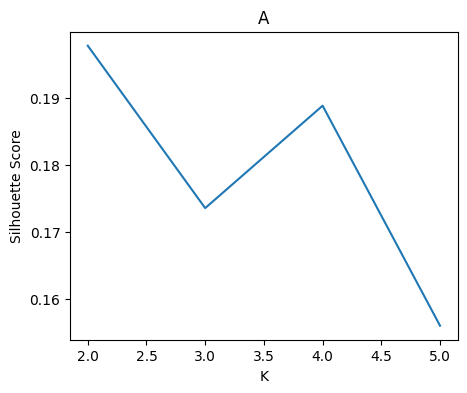

                    INFO     2025-07-18 23:42:49,538 neurocaps.analysis.cap._internals.cluster       ]8;id=649141;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=748645;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#288\288]8;;\
                             [INFO] [GROUP: B | METHOD: silhouette] Optimal cluster size is 2.                     

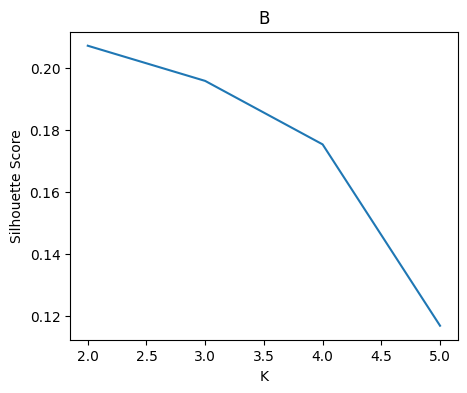

In [13]:
# Initializing CAP class and performing the elbow method
cap_analysis = CAP(groups={"A": ["0004"], "B": ["0006"]})

# Setting parcel approach instead of assigning it during initialization of the CAP class
cap_analysis.parcel_approach = parcel_approach

# Perform clustering with `n_cores`, which can be used to run kmeans in parallel when Used when `n_clusters` is a list
cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 6),
    cluster_selection_method="silhouette",
    n_cores=2,
    show_figs=True,
    figsize=(5, 4),
)

In [14]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : A, B
Number of Clusters                                          : [2, 3, 4, 5]
Cluster Selection Method                                    : silhouette
Optimal Number of Clusters (if Range of Clusters Provided)  : {'A': 2, 'B': 2}
CPU Cores Used for Clustering (Multiprocessing)             : 2
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 105784 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'A': 2, 'B': 2}
Variance Explained by Clustering                            : {'A': np.float64(0.26247958924686154), 'B': np.float64(0.2560715136159186)}


<font size="6">Calculating CAPs Metrics With Groups</font>

 <font size="3">Note, all groups are in the same dataframe for simplicity purposes (except for "transition_probability" where each group has separate dataframes) but use their own kmeans models to calculate each metric. Consequently, "CAP-1" and "CAP-2" are different for each group. In cases where the optimal cluster size for each group differs, values assigned as NaN is just indicates that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject.</font>

In [15]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0004,A,run-1,0.277778,0.722222
1,0004,A,run-2,0.518519,0.481481
2,0006,B,run-1,0.378378,0.621622
3,0006,B,run-2,0.406250,0.593750


In [16]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,0004,A,run-1,4,5
1,0004,A,run-2,5,5
2,0006,B,run-1,8,7
3,0006,B,run-2,6,6


 <font size="6">Calculating CAP Metrics and Treating Separate Runs as Continuous Runs </font>

In [17]:
metrics = cap_analysis.calculate_metrics(
    subject_timeseries=extractor.subject_timeseries,
    metrics="transition_probability",
    continuous_runs=True,
)

metrics["transition_probability"]["A"]

,Subject_ID,Group,Run,1.1,1.2,2.1,2.2
0,0004,A,run-continuous,0.652174,0.347826,0.230769,0.769231


  <font size="6">Transition Probability Matrix</font>
  
 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

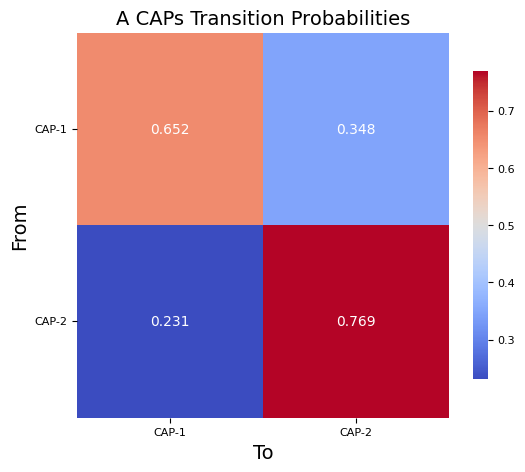

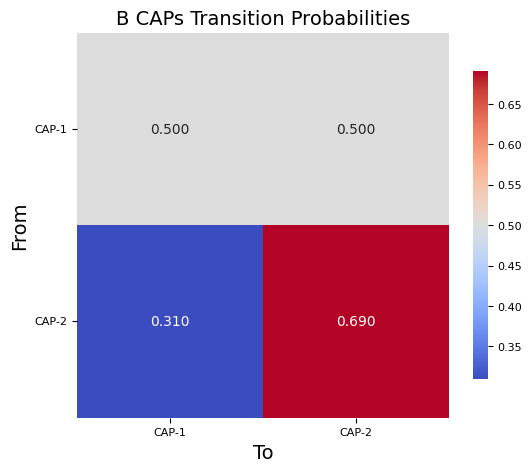

,CAP-1,CAP-2
From/To,,
CAP-1,0.500000,0.500000
CAP-2,0.309524,0.690476


In [18]:
from neurocaps.analysis import transition_matrix

trans_df = transition_matrix(
    trans_dict=metrics["transition_probability"],
    return_df=True,
    show_figs=True,
    annot=True,
    fmt=".3f",
    figsize=(6, 5),
)

trans_df["B"]

<font size="6">Plotting CAPs as Outer Products and Heatmaps </font>

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `self.caps2plot` method.</font>

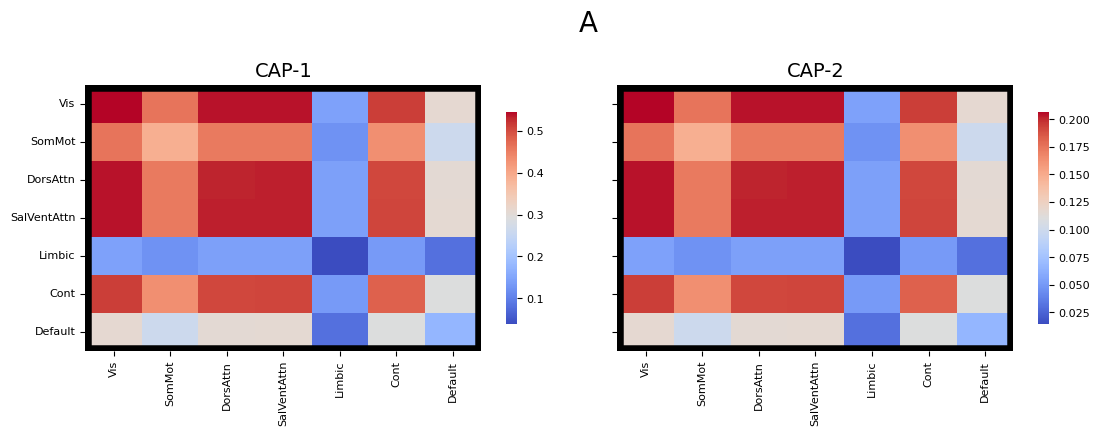

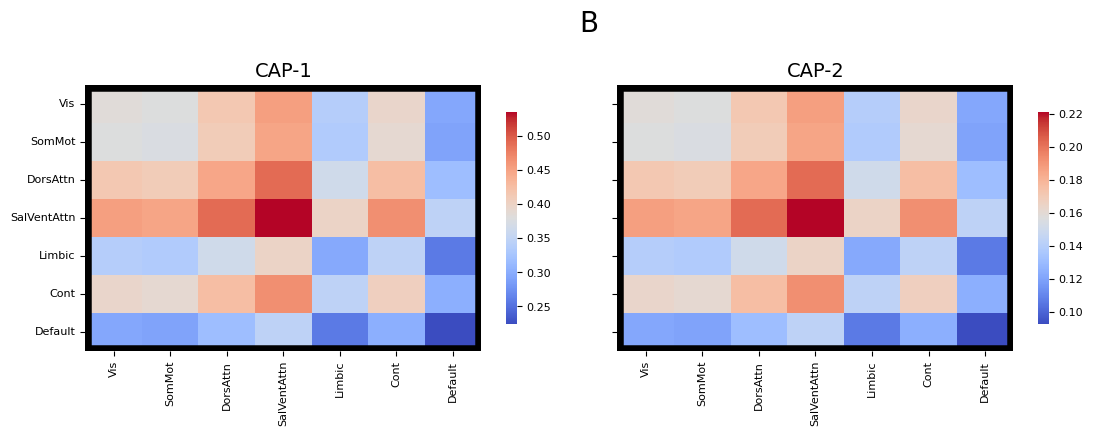

In [19]:
cap_analysis.caps2plot(
    plot_options="outer_product",
    subplots=True,
    xlabel_rotation=90,
    sharey=True,
    borderwidths=9,
    figsize=(11, 4),
    tight_layout=True,
)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `self.caps2plot` method.</font>

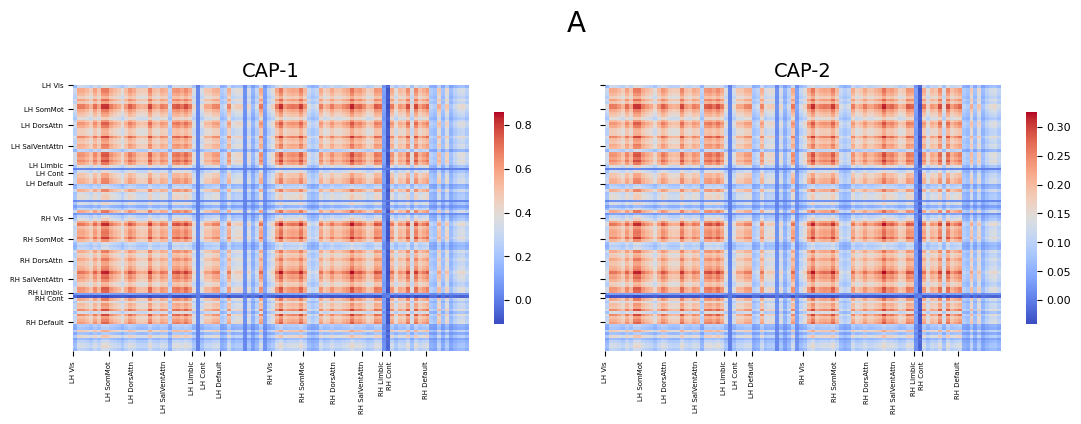

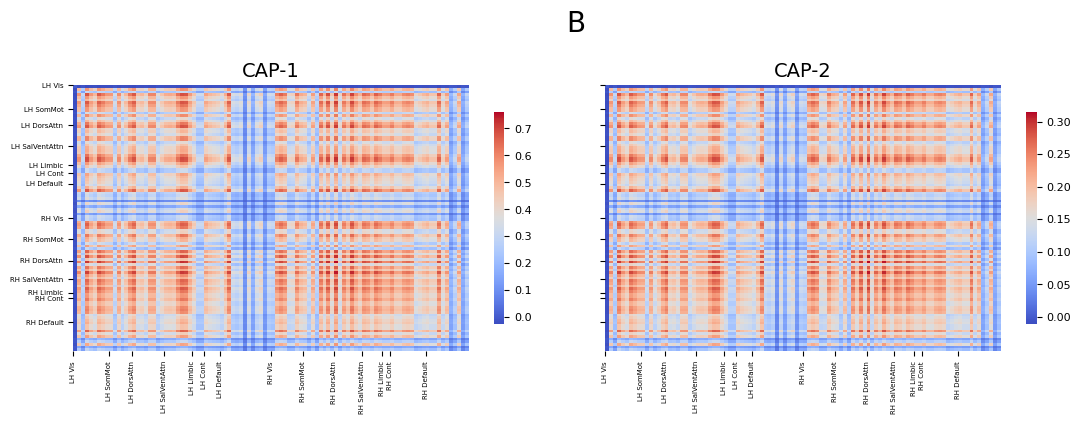

In [20]:
cap_analysis.caps2plot(
    plot_options="outer_product",
    visual_scope="nodes",
    subplots=True,
    yticklabels_size=5,
    wspace=0.1,
    xlabel_rotation=90,
    xticklabels_size=5,
    hspace=0.6,
    tight_layout=True,
    figsize=(11, 4),
)

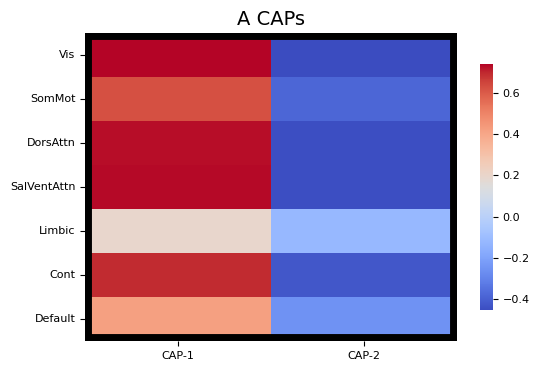

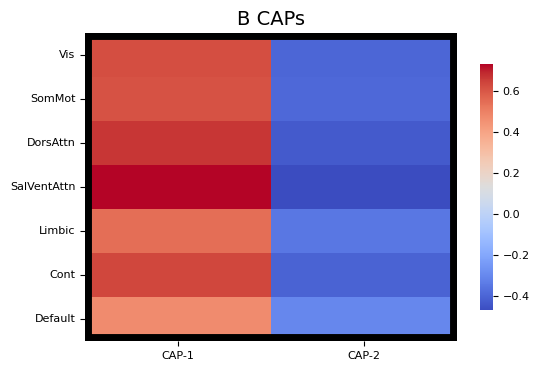

In [21]:
cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="heatmap",
    subplots=True,
    borderwidths=10,
    figsize=(6, 4)
)

 <font size="6">Merging Different Timeseries Across Sessions or Tasks </font>

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `self.calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [22]:
# Extract the Retino data
extractor.get_bold(
    bids_dir="neurocaps_demo", task="Retino", tr=2, condition_tr_shift=2, slice_time_ref=1
)

extractor.timeseries_to_pickle(output_dir=output_dir, filename="Retino_timeseries.pkl")

[07/18/25 23:42:51] WARNING  2025-07-18 23:42:51,509                                    ]8;id=399594;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py\timeseries_extractor.py]8;;\:]8;id=183425;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py#750\750]8;;\
                             neurocaps.extraction.timeseries_extractor [WARNING]                                   
                             `condition_tr_shift` specified but `condition` is None.                               

                    WARNING  2025-07-18 23:42:51,509                                    ]8;id=254945;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py\timeseries_extractor.py]8;;\:]8;id=637118;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseries_extractor.py#759\759]8;;\
                             neurocaps.extraction.timeseries_extractor [WARNING]                                   
                             `slice_time_ref` specified but `condition` is None.                                   

                    INFO     2025-07-18 23:42:51,825 neurocaps.extraction._internals.postprocess ]8;id=258677;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=983395;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1]                           
                             Preparing for Timeseries Extraction using [FILE:                                      
                             sub-0004_ses-2_task-Retino_run-1_space-MNI152NLin6Asym_res-2_desc-p                   
                             reproc_bold.nii.gz].                                                                  

                    INFO     2025-07-18 23:42:51,844 neurocaps.extraction._internals.postprocess ]8;id=733972;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=318531;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1] No                        
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:42:51,850 neurocaps.extraction._internals.postprocess ]8;id=736595;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=521370;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 1] The                       
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, trans_x, trans_x_derivative1, trans_y,                                      
                             trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                             
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_27,                       
                             a_comp_cor_28.                                                                        

[07/18/25 23:42:59] INFO     2025-07-18 23:42:59,399 neurocaps.extraction._internals.postprocess ]8;id=122219;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=964299;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 2]                           
                             Preparing for Timeseries Extraction using [FILE:                                      
                             sub-0004_ses-2_task-Retino_run-2_space-MNI152NLin6Asym_res-2_desc-p                   
                             reproc_bold.nii.gz].                                                                  

                    INFO     2025-07-18 23:42:59,419 neurocaps.extraction._internals.postprocess ]8;id=370632;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=293846;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 2] No                        
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:42:59,426 neurocaps.extraction._internals.postprocess ]8;id=992332;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=385748;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0004 | SESSION: 2 | TASK: Retino | RUN: 2] The                       
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, trans_x, trans_x_derivative1, trans_y,                                      
                             trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                             
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_24,                       
                             a_comp_cor_25.                                                                        

[07/18/25 23:43:06] INFO     2025-07-18 23:43:06,275 neurocaps.extraction._internals.postprocess ]8;id=44861;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=538011;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 1]                           
                             Preparing for Timeseries Extraction using [FILE:                                      
                             sub-0006_ses-2_task-Retino_run-1_space-MNI152NLin6Asym_res-2_desc-p                   
                             reproc_bold.nii.gz].                                                                  

                    INFO     2025-07-18 23:43:06,296 neurocaps.extraction._internals.postprocess ]8;id=577915;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=751875;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 1] No                        
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:43:06,302 neurocaps.extraction._internals.postprocess ]8;id=909975;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=186755;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 1] The                       
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, trans_x, trans_x_derivative1, trans_y,                                      
                             trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                             
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_19,                       
                             a_comp_cor_20.                                                                        

[07/18/25 23:43:13] INFO     2025-07-18 23:43:13,213 neurocaps.extraction._internals.postprocess ]8;id=234362;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=661646;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#302\302]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 2]                           
                             Preparing for Timeseries Extraction using [FILE:                                      
                             sub-0006_ses-2_task-Retino_run-2_space-MNI152NLin6Asym_res-2_desc-p                   
                             reproc_bold.nii.gz].                                                                  

                    INFO     2025-07-18 23:43:13,233 neurocaps.extraction._internals.postprocess ]8;id=606530;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=661359;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#368\368]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 2] No                        
                             'non_steady_state_outlier_XX' columns were found so 0 dummy scans                     
                             will be removed.                                                                      

                    INFO     2025-07-18 23:43:13,238 neurocaps.extraction._internals.postprocess ]8;id=681368;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py\postprocess.py]8;;\:]8;id=55130;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\_internals\postprocess.py#799\799]8;;\
                             [INFO] [SUBJECT: 0006 | SESSION: 2 | TASK: Retino | RUN: 2] The                       
                             following confounds will be used for nuisance regression: cosine00,                   
                             cosine01, trans_x, trans_x_derivative1, trans_y,                                      
                             trans_y_derivative1, trans_z, trans_z_derivative1, rot_x,                             
                             rot_x_derivative1, rot_y, rot_y_derivative1, rot_z,                                   
                             rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_19,                       
                             a_comp_cor_20.                                                                        

In [23]:
# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(
    subject_timeseries_list=[
        f"{output_dir}/DET_timeseries.pkl",
        f"{output_dir}/Retino_timeseries.pkl",
    ],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

 <font size="6">Identifying CAPs in Merged Timeseries </font>

 <font size="3">Generating examples not using the `group` parameter. Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group. The merged timeseries in `all_dicts` which was generated in the previous cell will be used as input here.</font>

In [24]:
cap_analysis = CAP(
    parcel_approach={"Schaefer": {"n_rois": 100, "resolution_mm": 1, "yeo_networks": 7}}
)

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

[07/18/25 23:43:20] INFO     2025-07-18 23:43:20,323 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=595813;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=144136;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#75\75]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

 <font size="6">Calculating CAP Metrics on Subsets of Merged Timeseries </font>

In [25]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2]
)

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,All Subjects,run-1,0.194444,0.583333,0.222222
1,0004,All Subjects,run-2,0.407407,0.296296,0.296296
2,0006,All Subjects,run-1,0.297297,0.459459,0.243243
3,0006,All Subjects,run-2,0.281250,0.406250,0.312500


In [26]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2], continuous_runs=True
)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,0004,All Subjects,run-continuous,2.370370,1.660000,2.111111
1,0006,All Subjects,run-continuous,3.769231,3.692308,3.916667


In [27]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2]
)

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,0004,All Subjects,run-1,55
1,0004,All Subjects,run-2,47
2,0006,All Subjects,run-1,24
3,0006,All Subjects,run-2,25


<font size="6">CAPs Correlation Matrix </font>

 <font size="3">`self.caps2corr` can be used to obtain the Pearson or Spearman correlation between CAPs and to obtain a dataframe of the uncorrected p-values.</font>

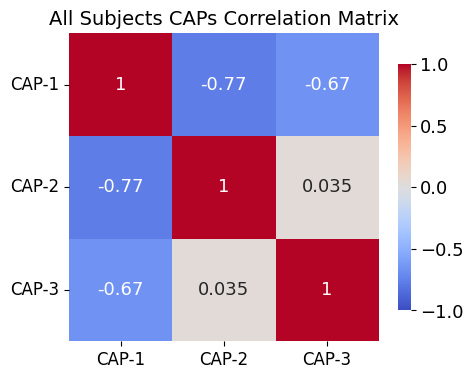

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.77 (1.2e-20)***,-0.67 (3.4e-14)***
CAP-2,-0.77 (1.2e-20)***,1 (0)***,0.035 (0.73)
CAP-3,-0.67 (3.4e-14)***,0.035 (0.73),1 (0)***


In [28]:
corr_df = cap_analysis.caps2corr(
    method="pearson",
    return_df=True,
    annot=True,
    figsize=(5, 4),
    xticklabels_size=12,
    yticklabels_size=12,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 13},
    cbarlabels_size=13,
)

corr_df["All Subjects"]

 <font size="6">CAPs Surface Plots </font> 
 
 <font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

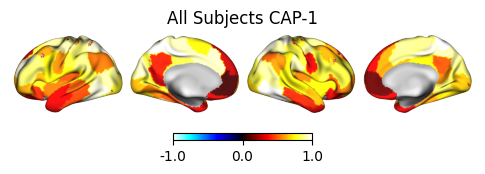

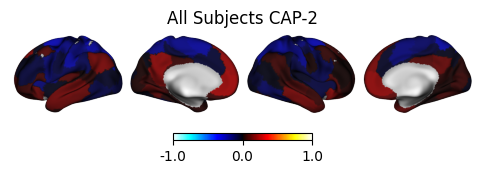

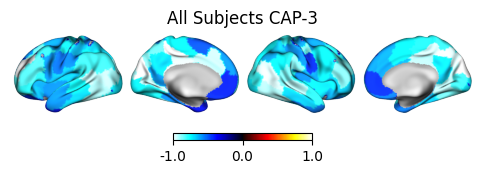

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

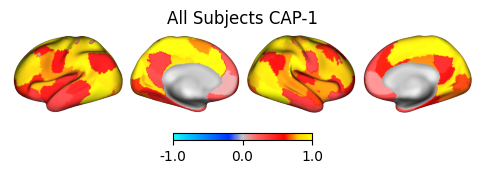

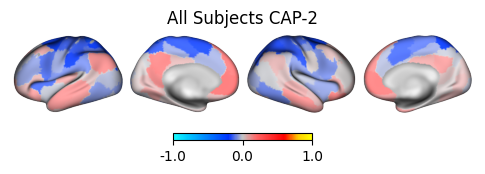

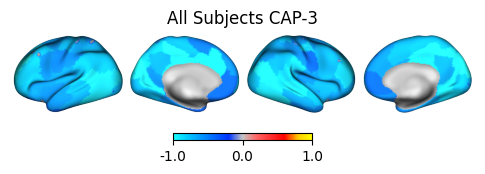

In [29]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

cap_analysis.caps2surf(cmap="cold_hot", layout="row", color_range=(-1, 1), size=(500, 100))

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

cap_analysis.caps2surf(
    progress_bar=True,
    cmap=custom_cmap,
    size=(500, 100),
    color_range=(-1, 1),
    layout="row",
    surface="veryinflated",
)

 <font size="6">CAPs to NifTIs </font>

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `self.caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [30]:
cap_analysis.caps2niftis(
    output_dir=output_dir, suffix_filename="for_neurocaps_demo", progress_bar=True
)

Generating Statistical Maps [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

<font size="6">CAPs to Radar Plots </font>

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. Since this function assumes that the matrix subjected to kmeans clustering was standardized, "High Amplitude" represents values above the mean (0) and "Low Amplitude" represents values below the mean (0). During calculation of the "Low Amplitude" cosine similarity, the inverse is computed to turn this similarity positive for visualization purposes.</font>

In [31]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.8],
    "tickvals": ["", 0.2, "", 0.4, "", 0.6, "", 0.8],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "black", "Low Amplitude": "orange"}

cap_analysis.caps2radar(
    radialaxis=radialaxis, height=400, width=600, color_discrete_map=colors, legend=legend
)

C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\radar.py:88: RuntimeWarning:

invalid value encountered in scalar divide



 <font size="3">The cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [32]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])

df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]

print(df)

   High Amplitude  Low Amplitude      Regions
0        0.425759            NaN          Vis
1        0.373852            NaN       SomMot
2        0.476563            NaN     DorsAttn
3        0.398565            NaN  SalVentAttn
4        0.107960            NaN       Limbic
5        0.366216            NaN         Cont
6        0.328596            NaN      Default


<font size="6">Using Custom Parcellations </font>

 <font size="3">The NeuroCAPs package uses Nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. NeuroCAPs can also accept additional parcellations. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.
 
 Refer to [Tutorial 7](https://neurocaps.readthedocs.io/en/stable/examples/custom.html) for the different methods to create a Custom parcellation
 </font>

In [33]:
import json

from neurocaps.utils import fetch_preset_parcel_approach

parcel_approach = fetch_preset_parcel_approach("HCPex")

with open(os.path.join("neurocaps_demo", "HCPex.json"), "w") as f:
    json.dump(parcel_approach, f)

In [34]:
extractor.parcel_approach = os.path.join("neurocaps_demo", "HCPex.json")

extractor.get_bold(
    bids_dir="neurocaps_demo", session="2", task="DET", n_cores=2, tr=2, verbose=False
)

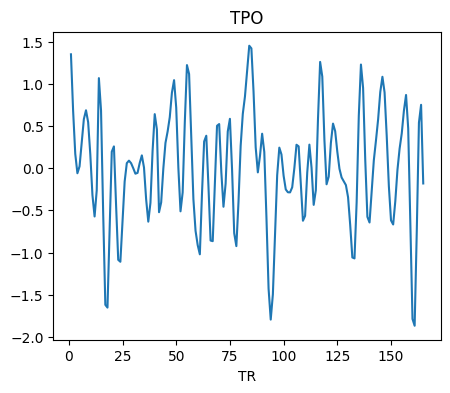

In [35]:
extractor.visualize_bold(subj_id="0006", run=1, region="TPO", figsize=(5, 4))

<font size="3">For "Custom" parcel approaches, all visualization methods can be used.

[07/18/25 23:44:12] INFO     2025-07-18 23:44:12,672 neurocaps.analysis.cap._internals.cluster [INFO] ]8;id=950294;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=141381;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#75\75]8;;\
                             No groups specified. Using default group 'All Subjects' containing all                
                             subject IDs from `subject_timeseries`. The `groups` dictionary will                   
                             remain fixed unless the `CAP` class is re-initialized or                              
                             `clear_groups()` is used.                                                             

                    INFO     2025-07-18 23:44:12,789 neurocaps.analysis.cap._internals.cluster       ]8;id=80963;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py\cluster.py]8;;\:]8;id=62531;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap\_internals\cluster.py#288\288]8;;\
                             [INFO] [GROUP: All Subjects | METHOD: elbow] Optimal cluster size is 5.               

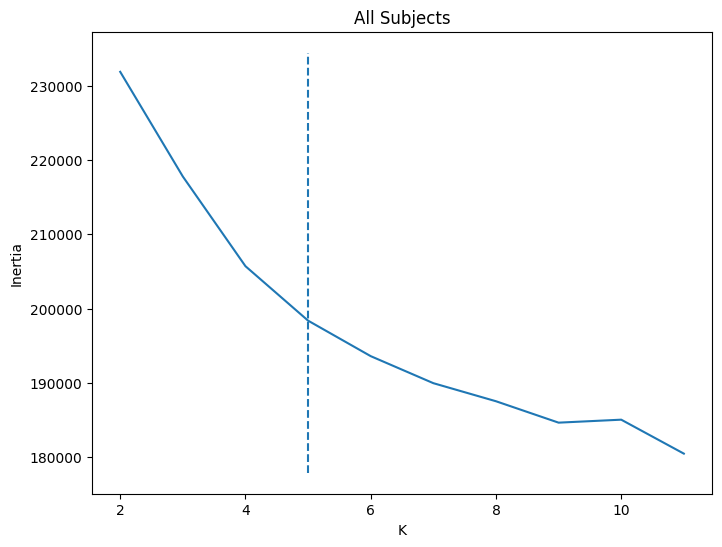

In [36]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    cluster_selection_method="elbow",
    show_figs=True,
    n_clusters=range(2, 12),
)

In [37]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.2, "", 0.4, "", 0.6],
}

color_discrete_map = {"High Amplitude": "rgba(255, 165, 0, 0.75)", "Low Amplitude": "black"}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir=output_dir,
    plot_output_format="html",
)

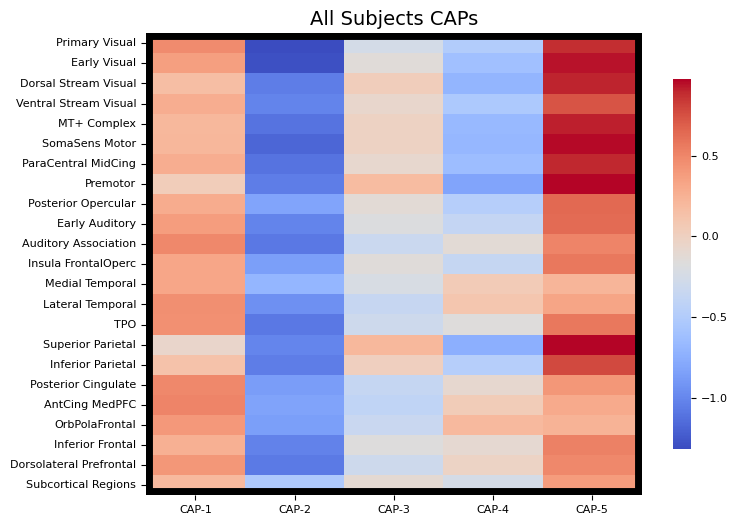

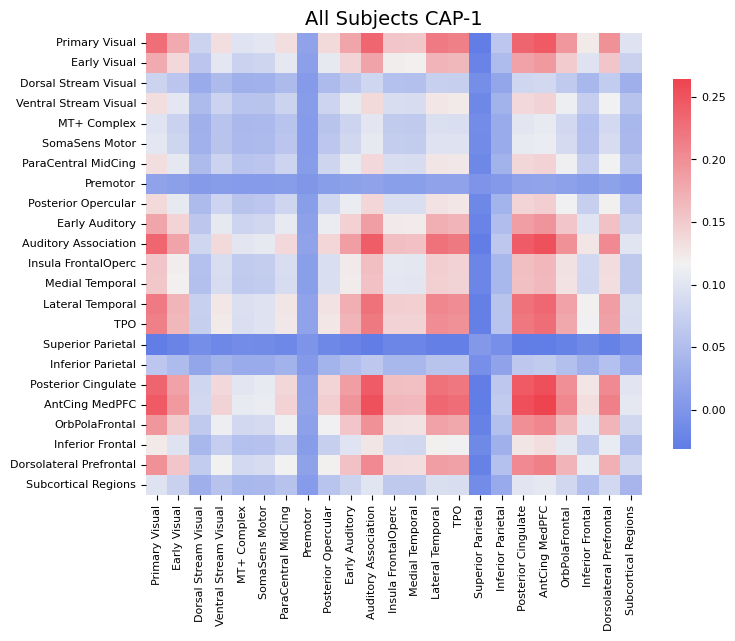

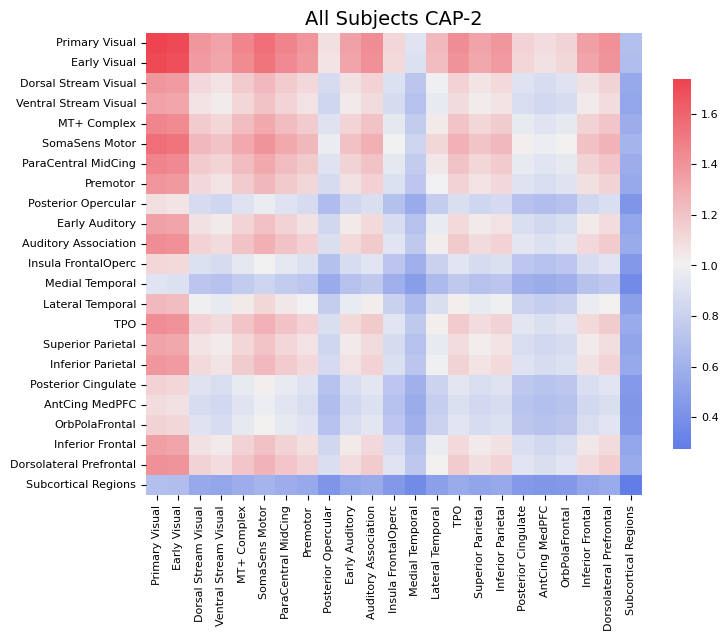

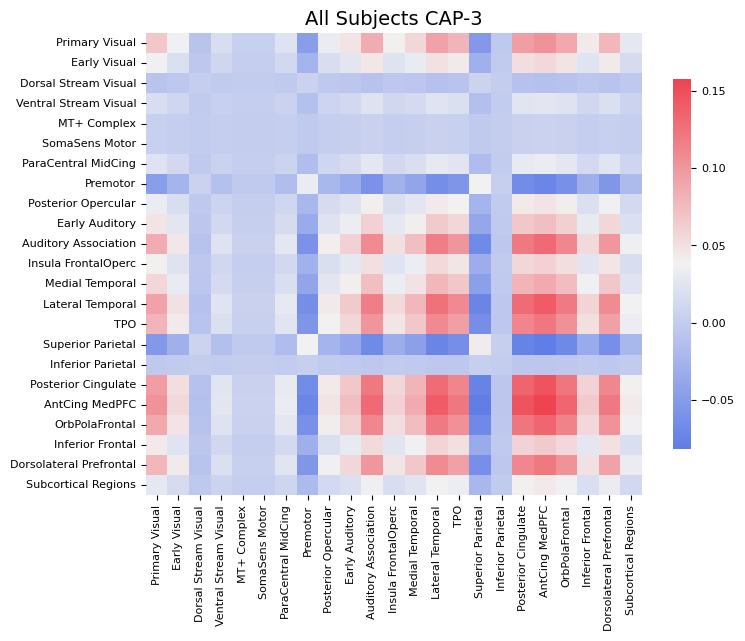

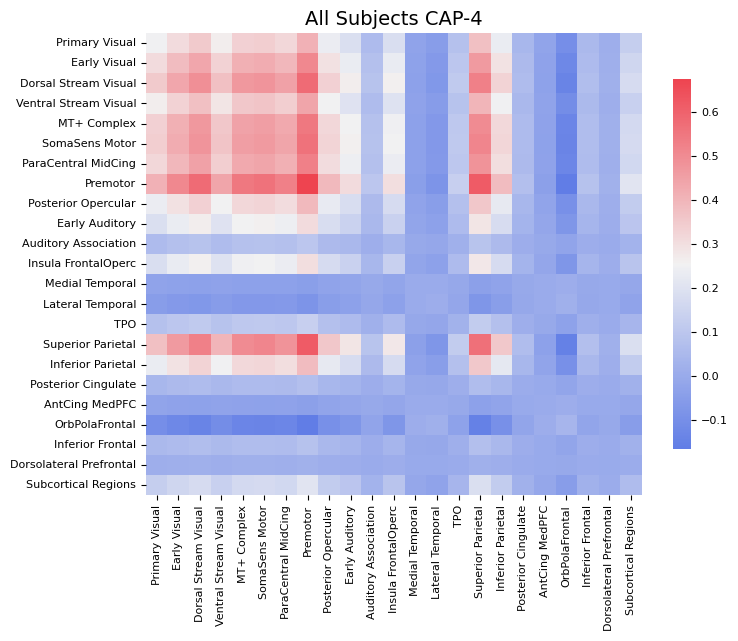

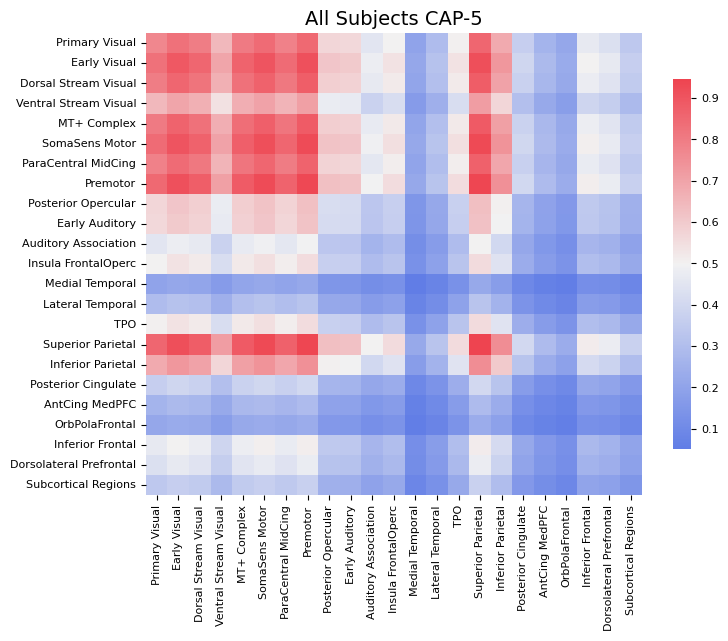

In [38]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir=output_dir,
)

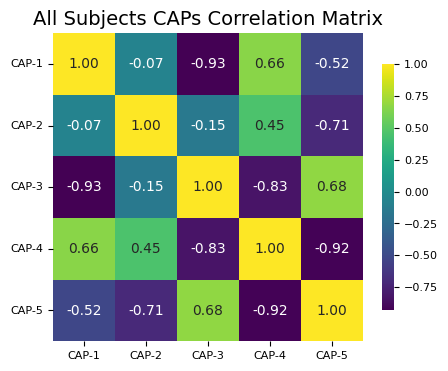

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5
0,0004,All Subjects,run-continuous,4.054054,4.100000,5.125000,3.757576,5.357143
1,0006,All Subjects,run-continuous,5.625000,4.571429,4.923077,4.521739,4.428571


In [39]:
cap_analysis.caps2corr(annot=True, cmap="viridis", fmt=".2f", figsize=(5, 4), output_dir=output_dir)

outputs = cap_analysis.calculate_metrics(
    subject_timeseries=extractor.subject_timeseries,
    tr=2,
    continuous_runs=True,
    metrics=["persistence", "transition_probability"],
    output_dir=output_dir,
)

outputs["persistence"]

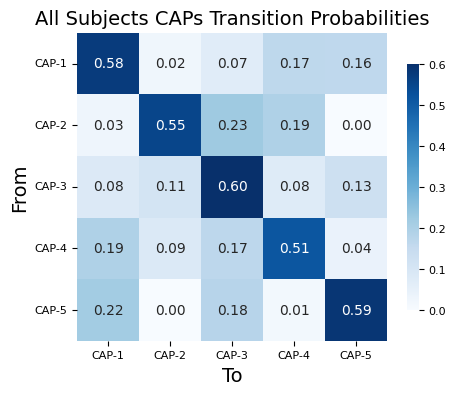

,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5
From/To,,,,,
CAP-1,0.575556,0.024444,0.070000,0.165556,0.164444
CAP-2,0.028629,0.552823,0.225403,0.193145,0.000000
CAP-3,0.084350,0.108740,0.601753,0.076474,0.128684
CAP-4,0.192928,0.086849,0.167184,0.512717,0.040323
CAP-5,0.218172,0.000000,0.179570,0.014731,0.587527


In [40]:
from neurocaps.analysis import transition_matrix

trans_df = transition_matrix(
    trans_dict=outputs["transition_probability"],
    return_df=True,
    annot=True,
    fmt=".2f",
    figsize=(5, 4),
    cmap="Blues",
)

trans_df["All Subjects"]

<font size="6">Using KNN to Fix Surface Plot Visualization Issues </font>

<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels (i.e. cortical parcellations converted into volumetric format), there is a `knn_dict` parameter in both `self.caps2surf` and `self.caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference. **This process may take a few minutes depending on your computer**.</font>

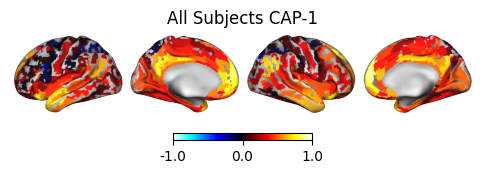

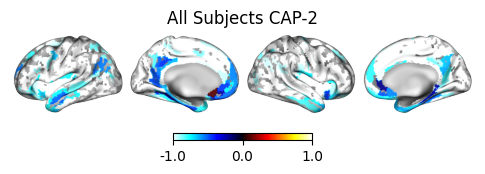

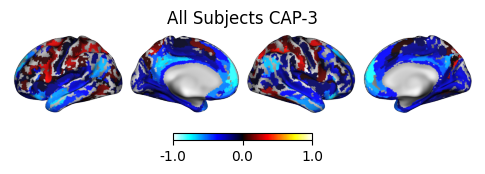

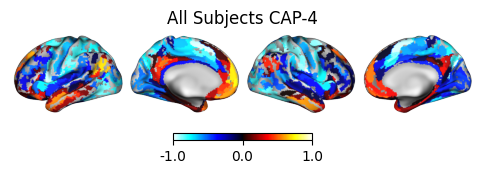

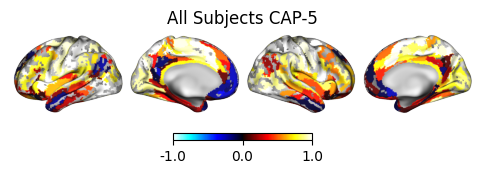

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/5 [00:00<?, ?it/s]

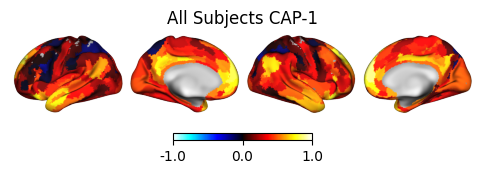

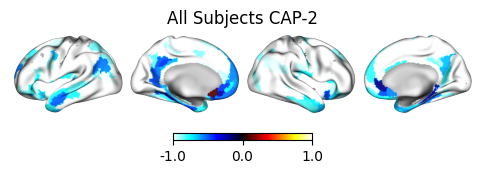

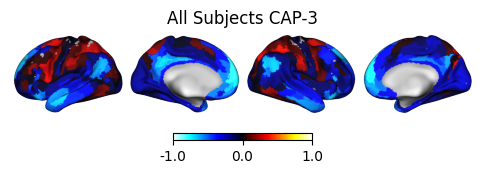

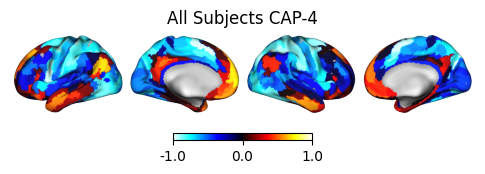

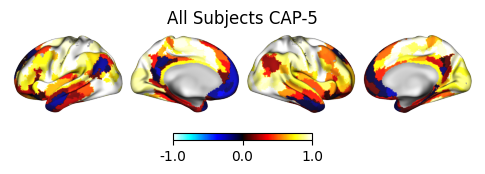

In [41]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
cap_analysis.caps2surf(method="nearest", size=(500, 100), layout="row", color_range=[-1, 1])

cap_analysis.caps2surf(
    method="nearest",
    knn_dict={"k": 5, "reference_atlas": "Schaefer", "resolution_mm": 1, "method": "majority_vote"},
    color_range=[-1, 1],
    save_stat_maps=True,
    output_dir=output_dir,
    progress_bar=True,
    size=(500, 100),
    layout="row",
)

<font size="6">Types </font>

<font size="3">Type definitions are offered in the `neurocaps.typing` module to assist in building the correct dictionary structure for parcellation configurations,
parcellation approaches, and subject timeseries when using a static type checker such as [Pylance](https://marketplace.visualstudio.com/items?itemName=ms-python.vscode-pylance).</font>

In [42]:
from neurocaps.typing import *

schaefer_config: SchaeferParcelConfig = {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 1}

parcel_config: ParcelConfig = {"Schaefer": schaefer_config}

# Set new parcellation configuration
extractor.parcel_approach = parcel_config

 <font size="3">Removes the files and directories generated in this demo.</font>

In [43]:
import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)